In [16]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [30]:
import warnings
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from prophet import Prophet
import pandas as pd
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

pd.Series(dtype='float64')

Series([], dtype: float64)

In [18]:
data = pd.read_csv('variable_selected_county_dataset.csv', index_col=0)

In [19]:
california_data = data[data['entity'] == 'California-Los Angeles']
california_data['date'] = pd.to_datetime(california_data['date'], format="%Y-%m-%d")
california_data['entity'].unique()

array(['California-Los Angeles'], dtype=object)

In [20]:
la = california_data[california_data['entity'] == 'California-Los Angeles'].loc[:, ['date', 'incremental_cases']]
la['incremental_cases'] = la['incremental_cases'].astype('int')
la['date'] = pd.to_datetime(la['date'], format="%Y-%m-%d")

In [23]:
# use 85%-15% for train-test split
train = la.iloc[:230, :]
test = la.iloc[230:, :]

train = train.reset_index().rename(columns={'date': 'ds', 'incremental_cases': 'y'})
test = test.reset_index().rename(columns={'date': 'ds', 'incremental_cases': 'y'})

# Check the shape of the dataset
print(train.shape)
print(test.shape)

(230, 3)
(40, 3)


In [25]:
# Use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

18:16:55 - cmdstanpy - INFO - Chain [1] start processing
18:16:55 - cmdstanpy - INFO - Chain [1] done processing


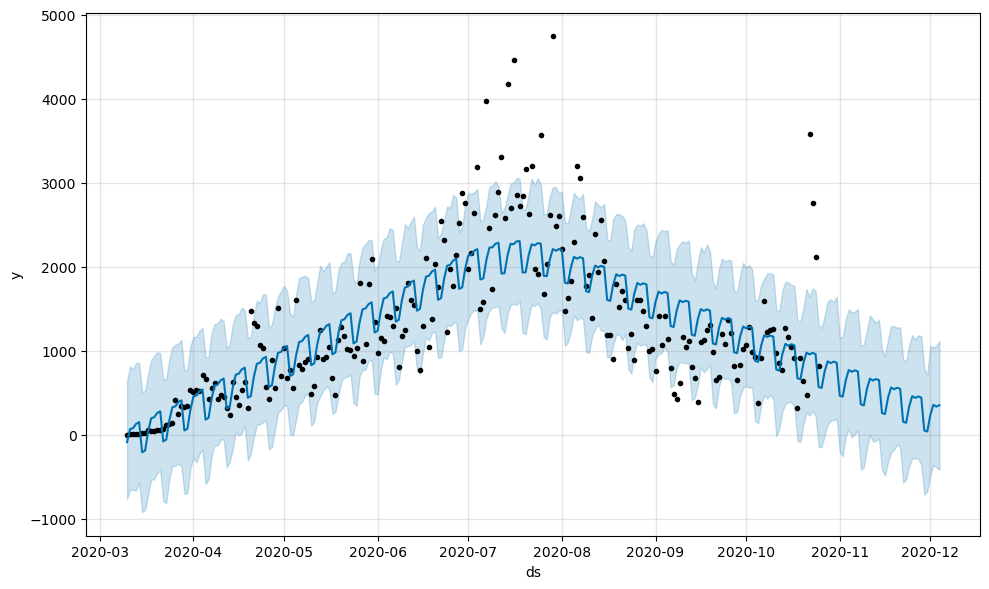

In [27]:
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=40)

# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)

# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

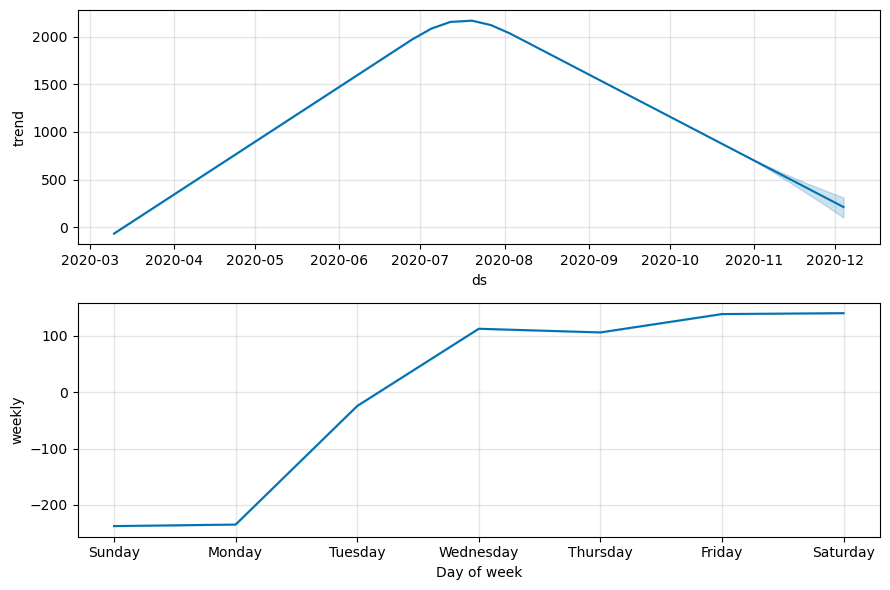

In [28]:
model_baseline.plot_components(forecast_baseline);


In [31]:
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 4804.2677815937495
The MAPE for the baseline model is 0.9266212980416171


In [32]:
print(f'There are {len(model_baseline.changepoints)} change points. \nThe change points dates are \n{train.loc[train["ds"].isin(model_baseline.changepoints)]}')


There are 25 change points. 
The change points dates are 
     index         ds     y
7      273 2020-03-17    50
15     369 2020-03-25   137
22     453 2020-04-01   507
29     537 2020-04-08   620
37     633 2020-04-16   358
44     717 2020-04-23  1073
51     801 2020-04-30   697
59     897 2020-05-08   869
66     981 2020-05-15   930
73    1065 2020-05-22  1015
81    1161 2020-05-30  2089
88    1245 2020-06-06  1293
95    1329 2020-06-13  1547
102   1413 2020-06-20  2027
110   1509 2020-06-28  2523
117   1593 2020-07-05  1496
124   1677 2020-07-12  3307
132   1773 2020-07-20  3158
139   1857 2020-07-27  2033
146   1941 2020-08-03  1621
154   2037 2020-08-11  1384
161   2121 2020-08-18   900
168   2205 2020-08-25   884
176   2301 2020-09-02  1414
183   2385 2020-09-09   618


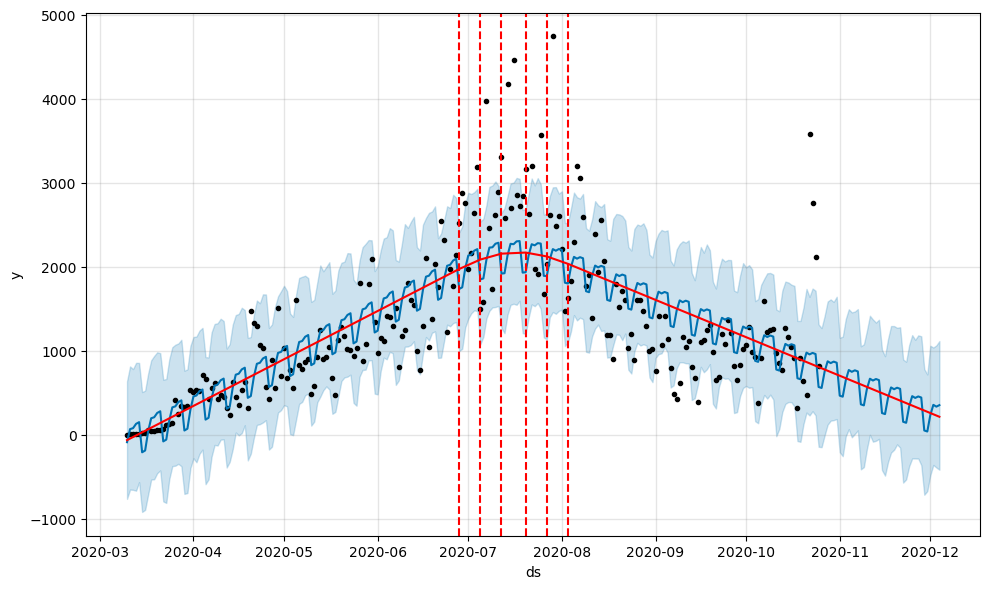

In [33]:
from prophet.plot import add_changepoints_to_plot

# Change points to plot
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)

In [35]:
# Create the prophet model with confidence internal of 95%
model_changepoint = Prophet(interval_width=0.95, n_changepoints=4)
# Fit the model using the training dataset
model_changepoint.fit(train)


18:20:12 - cmdstanpy - INFO - Chain [1] start processing
18:20:12 - cmdstanpy - INFO - Chain [1] done processing


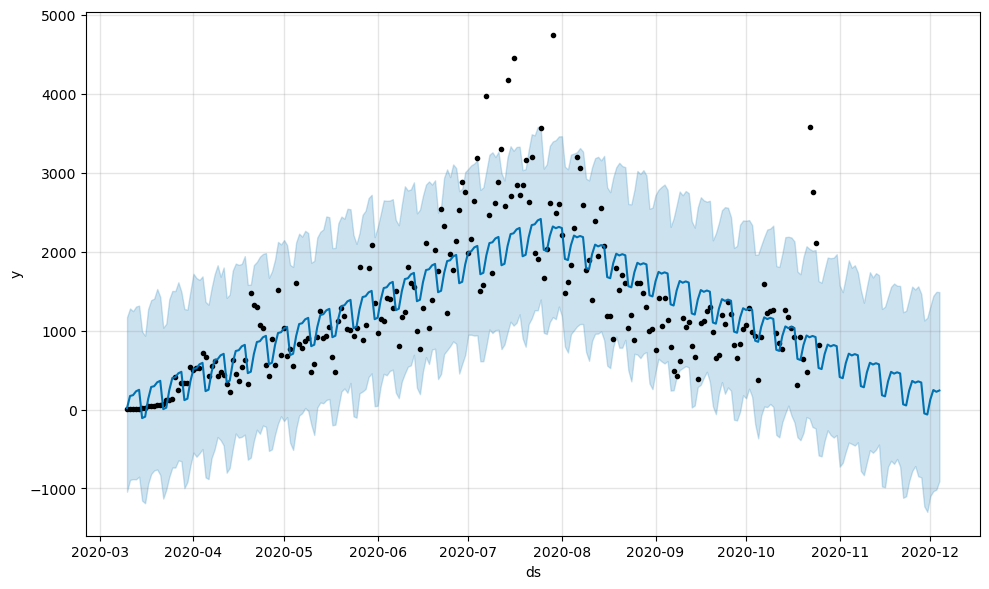

In [36]:
# Create the time range for the forecast
future_changepoint = model_changepoint.make_future_dataframe(periods=40)

# Make prediction
forecast_changepoint = model_changepoint.predict(future_changepoint)

# Visualize the forecast
model_changepoint.plot(forecast_changepoint); # Add semi-colon to remove the duplicated chart

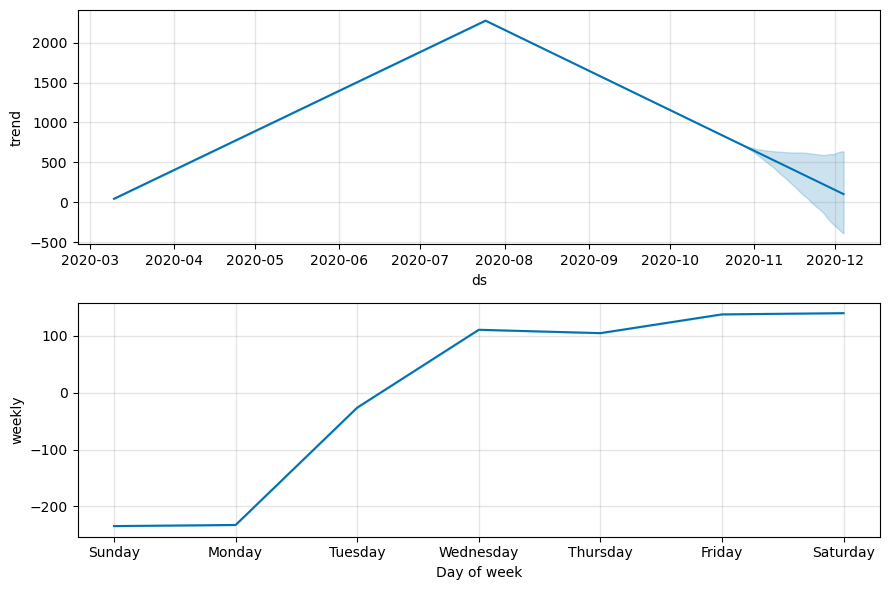

In [37]:
model_changepoint.plot_components(forecast_changepoint);


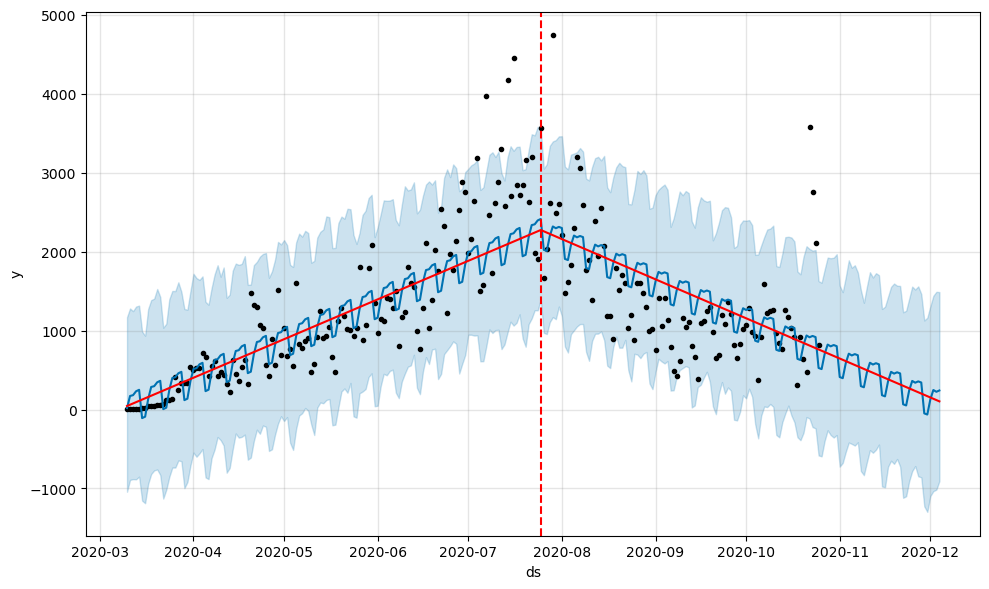

In [38]:
# Change points to plot
fig = model_changepoint.plot(forecast_changepoint)
a = add_changepoints_to_plot(fig.gca(), model_changepoint, forecast_changepoint)

In [39]:
# Merge actual and predicted values
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_changepoint_MAE = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MAE for the baseline model is {performance_changepoint_MAE}')

# Check MAPE value
performance_changepoint_MAPE = mean_absolute_percentage_error(performance_changepoint['y'], performance_changepoint['yhat'])
print(f'The MAPE for the baseline model is {performance_changepoint_MAPE}')

The MAE for the baseline model is 4900.872010580952
The MAPE for the baseline model is 0.9469727504961896


In [40]:
# Add holidays
model_holiday = Prophet( n_changepoints=1)

# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')


# Fit the model on the training dataset
model_holiday.fit(train)

# All the holidays and events
model_holiday.train_holiday_names

18:21:27 - cmdstanpy - INFO - Chain [1] start processing
18:21:27 - cmdstanpy - INFO - Chain [1] done processing
18:21:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:21:27 - cmdstanpy - INFO - Chain [1] start processing
18:21:27 - cmdstanpy - INFO - Chain [1] done processing


0                  New Year's Day
1                    Memorial Day
2                Independence Day
3     Independence Day (observed)
4                       Labor Day
5                    Veterans Day
6                    Thanksgiving
7                   Christmas Day
8      Martin Luther King Jr. Day
9           Washington's Birthday
10                   Columbus Day
dtype: object

In [42]:
model_multivariate = Prophet( n_changepoints=1)

In [43]:
model_multivariate.add_regressor('VTI', standardize=False)

In [44]:
model_multivariate.fit(train)

ValueError: Regressor 'VTI' missing from dataframe

In [45]:
from prophet import Prophet

# Initialize the Prophet model
model_multivariate = Prophet(n_changepoints=1)

# Add all other columns as regressors
for column in train.columns:
    if column not in ['ds', 'y']:  # Skip the target variable and datetime column
        model_multivariate.add_regressor(column)

# Fit the model to your training data
model_multivariate.fit(train)

# Create a future dataframe. The periods should match the length of your test set.
future = model_multivariate.make_future_dataframe(periods=len(test), freq='D') # Adjust 'freq' as per your data's frequency

# Since we're using all columns as regressors, we need to ensure the future dataframe includes these.
# Here, we'll assume your 'test' dataframe includes the necessary regressor values for the prediction period.
# Make sure to concatenate the future dataframe with the regressor values from your test set.

# This is a simplistic way to merge the future dataframe with your test set regressors.
# Adjust this as necessary for your actual data structure and needs.
for column in test.columns:
    if column not in ['ds', 'y']:  # Again, skipping the 'ds' and 'y' columns
        future[column] = test[column].values

# Predict
forecast = model_multivariate.predict(future)

# Evaluate the model as previously described


18:39:47 - cmdstanpy - INFO - Chain [1] start processing
18:39:47 - cmdstanpy - INFO - Chain [1] done processing
18:39:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:39:47 - cmdstanpy - INFO - Chain [1] start processing
18:39:47 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Length of values (40) does not match length of index (270)